In [42]:
%matplotlib inline 

#calling the Data from 1000 Genomes Project with Variant Call Format 
from cyvcf2 import VCF

vcf_path = "/Users/lisawilson/Documents/genomics/ALL.chr1.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"

vcf = VCF(vcf_path)
samples = vcf.samples

print(f"VCF loaded with {len(samples)} samples.")

VCF loaded with 2504 samples.


In [23]:
# CHROM= chromosome number, POS = position of chromosome, REF = reference allele, ALT = alternate allele, genotypes = 2 element list per sample. 
#First 5 variants 
for i, variant in enumerate(vcf):
    print(f"Variant {i+1}")
    print(f" CHROM: {variant.CHROM}")
    print(f" POS: {variant.POS}")
    print(f" REF: {variant.REF}")
    print(f" ALT: {variant.ALT}")
    print(f" Genotype Sample 0: {variant.genotypes[0]}")
    print("-" * 40)
    if i >=4:
        break
        

Variant 1
 CHROM: 1
 POS: 10177
 REF: A
 ALT: ['AC']
 Genotype Sample 0: [1, 0, True]
----------------------------------------
Variant 2
 CHROM: 1
 POS: 10235
 REF: T
 ALT: ['TA']
 Genotype Sample 0: [0, 0, True]
----------------------------------------
Variant 3
 CHROM: 1
 POS: 10352
 REF: T
 ALT: ['TA']
 Genotype Sample 0: [1, 0, True]
----------------------------------------
Variant 4
 CHROM: 1
 POS: 10505
 REF: A
 ALT: ['T']
 Genotype Sample 0: [0, 0, True]
----------------------------------------
Variant 5
 CHROM: 1
 POS: 10506
 REF: C
 ALT: ['G']
 Genotype Sample 0: [0, 0, True]
----------------------------------------


In [24]:
# first 10 samples ID number 
print(samples[:10]) #first 10 samples

['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102', 'HG00103', 'HG00105', 'HG00106', 'HG00107']


In [25]:
#SNP = Single Nucleotide Polymorphism, single letter difference in DNA sequence found at a specific position in the genome. 
#SNP table, rows = sample, column = variant(SNP)
from cyvcf2 import VCF
import pandas as pd 

vcf= VCF(vcf_path)

#dictionary: keys = sample IDs, values = list of dosages 
sample_ids = vcf.samples
snp_matrix = {sample: [] for sample in sample_ids}
snp_names = []
seen_positions = set() #no duplicate SNPs

#extract genotypes from first 100 biallelic SNPs
for i, variant in enumerate(vcf):
    pos = variant.POS

    if pos in seen_positions: 
        continue #skip duplicate positions
        
    if len(variant.REF) == 1 and variant.ALT and len(variant.ALT[0]) == 1: 
        snp_name = f"SNP_{variant.POS}"
        snp_names.append(snp_name)
        seen_positions.add(pos)

        for idx, sample in enumerate(sample_ids):
            gt = variant.genotypes[idx][:2]
            dosage = sum(gt)
            snp_matrix[sample].append(dosage)

        if len(snp_names) == 100:
            break
#change to DataFrame
snp_df = pd.DataFrame.from_dict(snp_matrix, orient="index", columns=snp_names)
snp_df.index.name = "SampleID"
snp_df.reset_index(inplace=True)

print(snp_df.head())

  SampleID  SNP_10505  SNP_10506  SNP_10511  SNP_10539  SNP_10542  SNP_10579  \
0  HG00096          0          0          0          0          0          0   
1  HG00097          0          0          0          0          0          0   
2  HG00099          0          0          0          0          0          0   
3  HG00100          0          0          0          0          0          0   
4  HG00101          0          0          0          0          0          0   

   SNP_10642  SNP_11008  SNP_11012  ...  SNP_17654  SNP_17694  SNP_17695  \
0          0          0          0  ...          0          0          0   
1          0          0          0  ...          0          0          0   
2          0          0          0  ...          0          0          0   
3          0          0          0  ...          0          0          0   
4          0          0          0  ...          0          0          0   

   SNP_17709  SNP_17748  SNP_17836  SNP_17922  SNP_18643  SNP_

In [26]:
import numpy as np 

#create mock beta weights 
beta_values = np.round(np.random.normal(loc=0.2, scale=0.05, size=len(snp_names)), 3)

#create dictionary: SNP name -> beta weight
beta_dict = dict(zip(snp_names, beta_values))

print("sample beta weights:")
for snp, beta in list(beta_dict.items())[:5]:
    print(f"{snp}: {beta}")

sample beta weights:
SNP_10505: 0.12
SNP_10506: 0.18
SNP_10511: 0.27
SNP_10539: 0.218
SNP_10542: 0.201


In [27]:
snp_df["PRS"] = snp_df[snp_names].apply(
    lambda row: sum(row[snp] * beta_dict[snp] for snp in snp_names),
    axis=1
)

print(snp_df[["SampleID", "PRS"]].head())

  SampleID    PRS
0  HG00096  2.129
1  HG00097  2.982
2  HG00099  3.139
3  HG00100  1.596
4  HG00101  2.099


In [28]:
#Label top 25% as high risk 
threshold = snp_df["PRS"].quantile(0.75)
snp_df["RiskLabel"] = (snp_df["PRS"] >= threshold).astype(int)

print(snp_df[["SampleID", "PRS", "RiskLabel"]].head())
print(f"High-risk PRS threshold: {threshold: .3f}")

  SampleID    PRS  RiskLabel
0  HG00096  2.129          0
1  HG00097  2.982          1
2  HG00099  3.139          1
3  HG00100  1.596          0
4  HG00101  2.099          0
High-risk PRS threshold:  2.598


In [29]:
#Train-Test split + Fit Logistic Regression 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#Define features (SNPs) and target (RiskLabel)
X = snp_df[snp_names]
y = snp_df["RiskLabel"]

#split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Train logistic regression model 
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

#Predict 
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [30]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", round(roc_auc_score(y_test, y_pred), 3))

Confusion Matrix:
[[454   3]
 [ 12 157]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       457
           1       0.98      0.93      0.95       169

    accuracy                           0.98       626
   macro avg       0.98      0.96      0.97       626
weighted avg       0.98      0.98      0.98       626

ROC AUC Score: 0.961


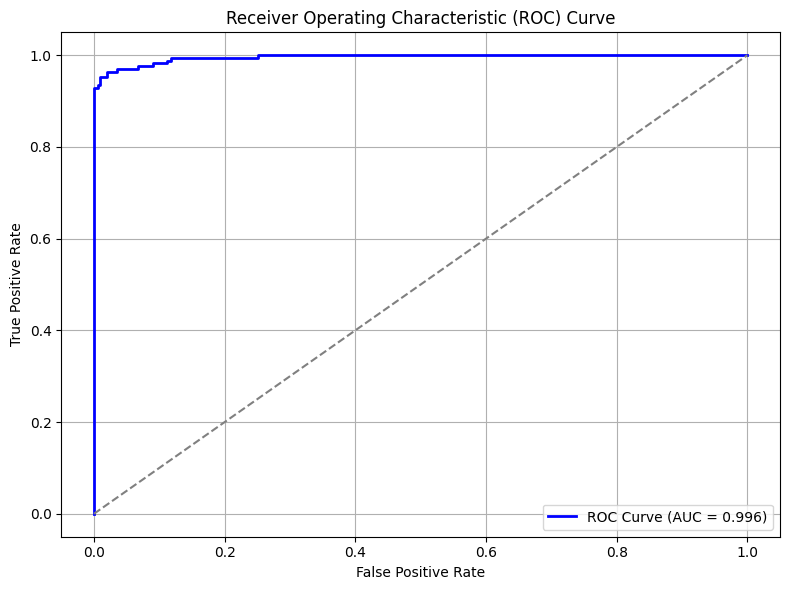

In [31]:
#Plot the ROC curve 
from sklearn.metrics import roc_curve, auc 
import matplotlib.pyplot as plt 

#Compute true/false positive rates
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

plt.savefig("receiver_operating_characteristic_curve", dpi=300)

plt.show()

In [32]:
#Feature importance

#Get model coefficents
feature_importance = pd.DataFrame({
    "SNP": snp_names,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

#show top 10 
print("Top 10 most predictive SNPs:")
print(feature_importance.head(10))

Top 10 most predictive SNPs:
          SNP  Coefficient
8   SNP_11012     3.159035
7   SNP_11008     3.159035
58  SNP_15774     3.080551
53  SNP_15274     2.999314
63  SNP_15820     2.910151
98  SNP_18849     2.438990
33  SNP_14599     2.428045
34  SNP_14604     2.428045
84  SNP_16949     2.274203
57  SNP_15644     2.215842


In [33]:
top_snps = feature_importance.head(10)

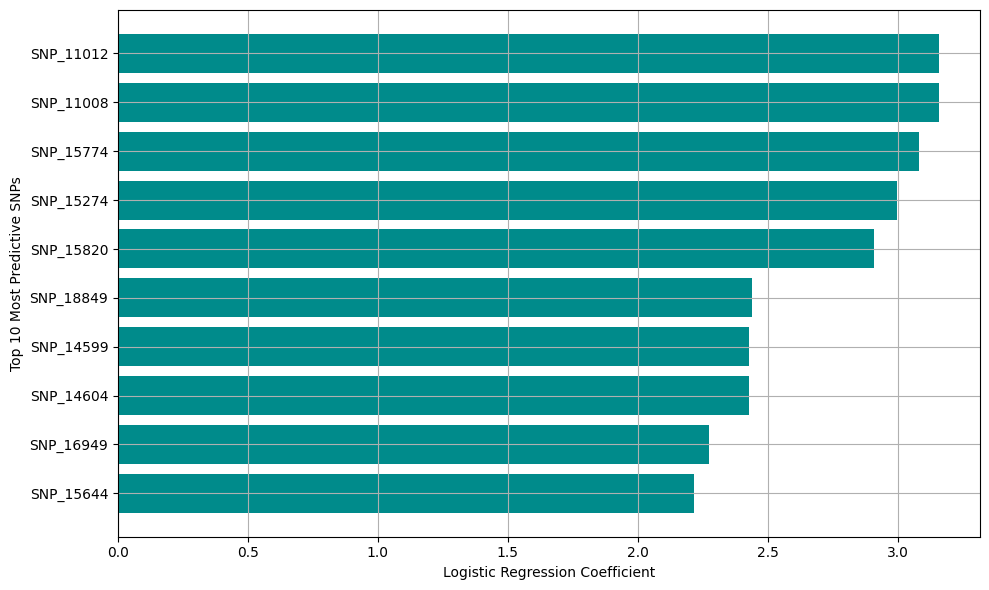

In [34]:
%matplotlib inline 

plt.figure(figsize = (10, 6))
plt.barh(top_snps["SNP"], top_snps["Coefficient"], color="darkcyan")
plt.xlabel("Logistic Regression Coefficient")
plt.ylabel("Top 10 Most Predictive SNPs")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()


plt.savefig("top_snps_feature_importance.png", dpi=300)

plt.show()

In [35]:
#define a function that will extract N biallelic SNPs, calculate PRS, label risk, train and evaluate a model, give and ROC curve, and give the top 10 features.

def run_prs_pipeline(vcf_path, num_snps):
    print(f"Running PRS pipeline with {num_snps} SNPs...")

    vcf = VCF(vcf_path)
    sample_ids = vcf.samples
    snp_matrix = {sample: [] for sample in sample_ids}
    snp_names = []
    seen_positions = set()

    for variant in vcf:
        pos = variant.POS
        if pos in seen_positions:
            continue
        if len(variant.REF) == 1 and variant.ALT and len(variant.ALT[0]) == 1:
            snp_name = f"SNP_{pos}"
            snp_names.append(snp_name)
            seen_positions.add(pos)
            for idx, sample in enumerate(sample_ids):
                gt = variant.genotypes[idx][:2]
                dosage = sum(gt)
                snp_matrix[sample].append(dosage)
            if len(snp_names) == num_snps:
                break
    #build Data Frame 
    snp_df = pd.DataFrame.from_dict(snp_matrix, orient="index", columns=snp_names)
    snp_df.index.name = "SampleID"
    snp_df.reset_index(inplace=True)

    #simulate beta weights and compute PRS
    beta_values = np.round(np.random.normal(loc=0.2, scale=0.05, size=num_snps), 3)
    beta_dict = dict(zip(snp_names, beta_values))

    snp_df["PRS"] = snp_df[snp_names].apply(
        lambda row: sum(row[snp] * beta_dict[snp]for snp in snp_names),
        axis=1
    )

    #Label top 25% as high risk 
    threshold = snp_df["PRS"].quantile(0.75)
    snp_df["RiskLabel"] = (snp_df["PRS"] >= threshold).astype(int)

    #Train model 
    X = snp_df[snp_names]
    y = snp_df["RiskLabel"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc_val = auc(fpr, tpr)
    
    accuracy = model.score(X_test, y_test)
    print(f" Accuracy: {accuracy:.3f} | AUC: {roc_auc_val:.3f}")

    #get top 10 features by absolute coefficient value 
    feature_importance = pd.DataFrame({
        "SNP": X.columns,
        "Coefficient": model.coef_[0]
    })
    top_snps = feature_importance.reindex(
        feature_importance.Coefficient.abs().sort_values(ascending=False).index
    ).head(10)["SNP"].tolist()

    return snp_df, model, beta_dict, roc_auc_val, accuracy, fpr, tpr,top_snps

In [36]:
#ROC curves for all SNP sets 

snp_sizes = [500, 1000, 10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000]
roc_data = {}
top_snp_tracker = {}


for n in snp_sizes:
    print(f"Running PRS pipeline with {n} SNPs...")
    snp_df, model, beta_dict, roc_auc_val, acc, fpr, tpr, top_snps = run_prs_pipeline(vcf_path, num_snps=n)
    roc_data[n] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc_val}
    top_snp_tracker[n] = top_snps


Running PRS pipeline with 500 SNPs...
Running PRS pipeline with 500 SNPs...
 Accuracy: 0.955 | AUC: 0.991
Running PRS pipeline with 1000 SNPs...
Running PRS pipeline with 1000 SNPs...
 Accuracy: 0.958 | AUC: 0.993
Running PRS pipeline with 10000 SNPs...
Running PRS pipeline with 10000 SNPs...
 Accuracy: 0.935 | AUC: 0.987
Running PRS pipeline with 20000 SNPs...
Running PRS pipeline with 20000 SNPs...
 Accuracy: 0.938 | AUC: 0.990
Running PRS pipeline with 30000 SNPs...
Running PRS pipeline with 30000 SNPs...
 Accuracy: 0.946 | AUC: 0.988
Running PRS pipeline with 40000 SNPs...
Running PRS pipeline with 40000 SNPs...
 Accuracy: 0.954 | AUC: 0.992
Running PRS pipeline with 50000 SNPs...
Running PRS pipeline with 50000 SNPs...
 Accuracy: 0.944 | AUC: 0.987
Running PRS pipeline with 100000 SNPs...
Running PRS pipeline with 100000 SNPs...
 Accuracy: 0.954 | AUC: 0.988
Running PRS pipeline with 200000 SNPs...
Running PRS pipeline with 200000 SNPs...
 Accuracy: 0.990 | AUC: 0.999
Running PRS 

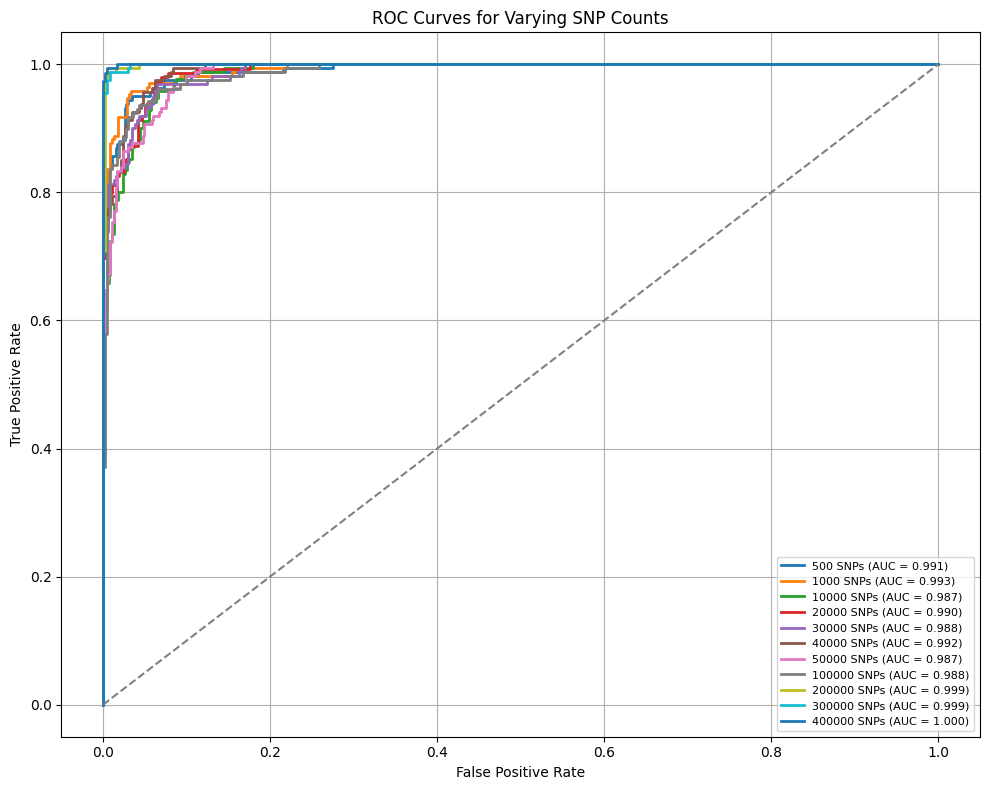

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

for snp_count, metrics in roc_data.items():
    plt.plot(metrics["fpr"], metrics["tpr"], lw=2,
             label=f"{snp_count} SNPs (AUC = {metrics['auc']:.3f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Varying SNP Counts")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()

plt.savefig("roc_curve_comparison.png", dpi=300)

plt.show()

In [43]:
from collections import Counter

all_top_snps = [snp for snps in top_snp_tracker.values() for snp in snps]

snp_frequency = Counter(all_top_snps)

top_snp_summary = pd.DataFrame(snp_frequency.items(), columns=["SNP", "Frequency"])
top_snp_summary = top_snp_summary.sort_values(by="Frequency", ascending=False)

print(top_snp_summary.head(10))

            SNP  Frequency
36   SNP_905160          4
52   SNP_905165          3
6     SNP_15820          3
1     SNP_58814          2
2     SNP_15211          2
75   SNP_871334          2
71  SNP_5847627          2
79  SNP_6605846          2
43  SNP_1410199          2
31   SNP_919489          2


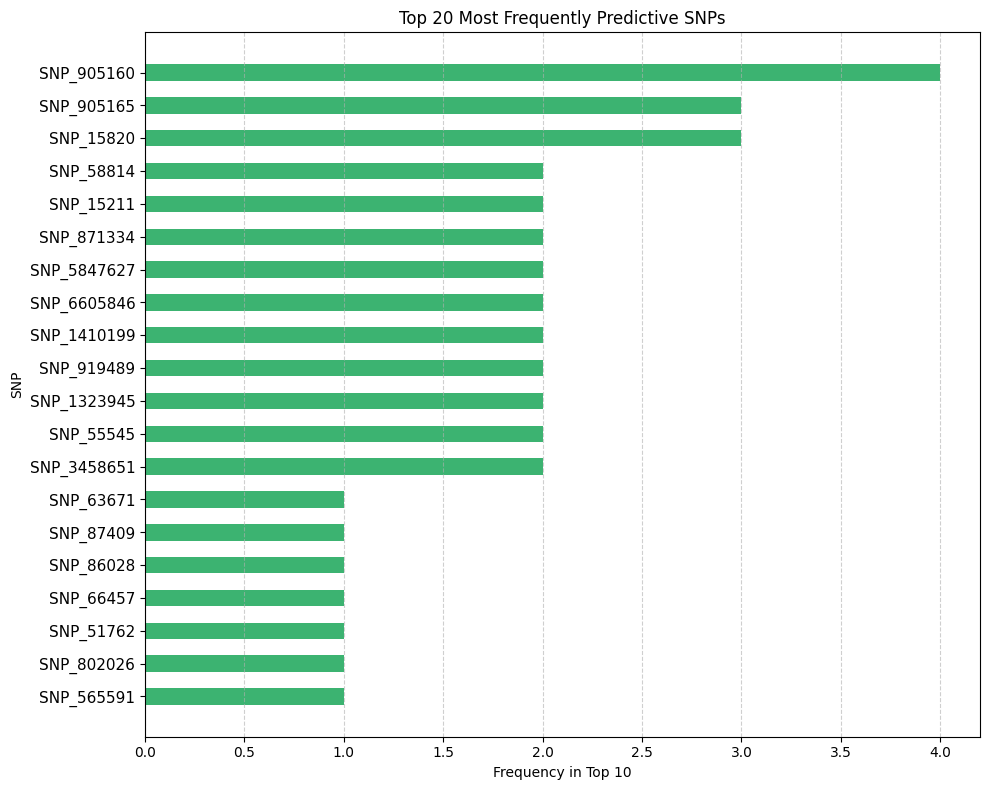

In [58]:
top_n = 20 
subset = top_snp_summary.head(top_n)

plt.figure(figsize=(10,8))
plt.barh(subset["SNP"], subset["Frequency"], height=0.5, color="mediumseagreen")
plt.xlabel("Frequency in Top 10")
plt.ylabel("SNP")
plt.title("Top 20 Most Frequently Predictive SNPs")
plt.yticks(fontsize=11)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("top_snps_frequency_top20.png", dpi=300)

plt.show()